This file is part of BrainMolecularAtlas.

It makes supp Figure 2A.

Copyright (c) 2021-2022 Blue Brain Project/EPFL 

This program is free software: you can redistribute it and/or modify
it under the terms of the GNU General Public License as published by
the Free Software Foundation, either version 3 of the License, or
(at your option) any later version.
This program is distributed in the hope that it will be useful,
but WITHOUT ANY WARRANTY; without even the implied warranty of
MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
GNU General Public License for more details.

You should have received a copy of the GNU General Public License
along with this program.  If not, see <https://www.gnu.org/licenses/>.

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import altair as alt

from numpy.random import seed
from numpy.random import randint
from scipy.stats import ks_2samp
from scipy.stats import levene
from scipy.stats import fligner
from scipy.stats import kruskal
import scikit_posthocs as sp

import scipy.stats as ss
from scipy.stats import mannwhitneyu

import pickle as pkl

pd.options.display.max_columns = None
pd.options.display.max_rows = None


%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
sns.set_style('whitegrid',{'axes.grid':False})

In [3]:
import pickle as pkl

with open('../data/6_df_processed.pkl','rb') as f:
    df = pkl.load(f)
print(len(df))

df["log_conc_uM_medNorm"]  = df["log_conc_uM_medNorm"].astype('float64')


custom_dict = {'Itzhak 2017':0,
               'Wisniewski 2015':1,
              'Bai 2020':2,
              'Hasan 2020':3,
              'Geiger 2013':4,
              'Kjell 2020':5,
              'Fecher 2019':6,
              'Guergues 2019':7,
              'Hamezah 2019':8,
              'McKetney 2019':9,
              'Hamezah 2018':10,
              'Krogager 2018':11,
              'Zhu 2018':12,
              'Carlyle 2017':13,
              'Sharma 2015, isolated':14,
              'Sharma 2015, cultured':15,
              'Han 2014':16,
              'Davis 2019':17,
              'Chuang 2018':18,
              'Fornasiero 2018':19,
              'Hosp 2017, insoluble':20,
              'Hosp 2017, soluble':21,
              'Hosp 2017, CSF':22,
              'Beltran 2016':23,
              'Duda 2018':24}   

df = df.iloc[df['Study'].map(custom_dict).argsort()]


df = df.reset_index(drop=True)

df['exp_conc'] = np.exp(df['log_conc_uM_medNorm'])


2131244


In [4]:
df['condition'].unique()

array([nan, 'AD', 'control',
       'LPC: low pathology of plaques and tangles. AD',
       'HPC: high Ab pathology but no detectable cognitive defects. AD',
       'AD: late-stage AD with high pathology scores of plaques and tangles',
       'MCI: mild cognitive impairment with Ab pathology and a slight but measurable defect in cognition. AD',
       'PSP: progressive supranuclear palsy, another neurodegenerative disorder of tauopathy',
       'EAE', 'Alzheimer', 'WT', 'AD_severe', 'AD_intermediate', 'SORT',
       'adult', 'young'], dtype=object)

In [25]:
len(df.loc[(df['Study']=='Carlyle 2017'),'gene_id_final'].unique())

4724

In [24]:
df.loc[(df['Study']=='Zhu 2018'),'Age_days'].unique()

array([38], dtype=object)

In [7]:
len(df.loc[(df['Study']=='Bai 2020') & (df['Organism']=='mouse'),'gene_id_final'].unique())

9291

In [6]:
df.loc[(df['Study']=='Bai 2020') & (df['Organism']=='human'),'location'].unique()

array(['cortex'], dtype=object)

In [4]:
df.columns

Index(['gene_names', 'Uniprot', 'Study', 'Organism', 'location', 'Age_cat',
       'Age_days', 'condition', 'sample_id', 'molecular_weight_kDa',
       'raw_data', 'raw_data_units', 'gene_name_unified', 'Uniprot_unified',
       'gene_id_final', 'log_raw_data', 'uniprot_from_gn', 'Uniprot_final',
       'TheorPepNum', 'conc_uM', 'log_conc_uM', 'copyNum', 'totalProtein',
       'totalVolume', 'sample_full_id', 'compound_gene_protein_id', 'row_id',
       'row_gene_id', 'gene_id_dd', 'log_conc_uM_medNorm', 'exp_conc'],
      dtype='object')

In [25]:
# normalized conc to copy num

def conc2cn(row):
    
    conc = row['exp_conc']
    totalVolume = row['totalVolume']
    
    avogadro = 6.02214129e23
    
    copyNum = conc*(totalVolume*1e-15)*avogadro/1e6 
    
    return(copyNum)

In [18]:
len(df.loc[~df['totalVolume'].isna()])/len(df)

0.995768199230121

In [28]:
df2 = df.copy()

In [29]:
df2 = df2.loc[~df['totalVolume'].isna()]

In [30]:
df2 = df2.drop(columns='copyNum') # drop old cn which are prior normaliz

In [31]:
df2['copyNum'] = df2.apply(conc2cn, axis=1)
    

In [36]:
df2['log_copyNum'] = np.log(df2['copyNum'])

In [43]:
df2 = df2.drop(columns=['gene_names', 'Uniprot', 'Study', 'Organism', 'location', 'Age_cat',
       'Age_days', 'condition', 'sample_id', 'molecular_weight_kDa',
       'raw_data', 'raw_data_units', 'gene_name_unified', 'Uniprot_unified',
        'log_raw_data', 'uniprot_from_gn', 'Uniprot_final',
       'TheorPepNum', 'conc_uM', 'log_conc_uM', 'totalProtein', 'totalVolume',
       'compound_gene_protein_id', 'row_id', 'row_gene_id',
       'gene_id_dd', 'log_conc_uM_medNorm', 'exp_conc','log_copyNum'])

In [44]:
df2.head()

,gene_id_final,sample_full_id,copyNum
9019,CREBBP,Wisniewski 2015_mouse_brain_91_nan_3,286.646185
9020,MAPK8IP1,Wisniewski 2015_mouse_brain_91_nan_3,3822.957634
9021,GNAS,Wisniewski 2015_mouse_brain_91_nan_1,259392.477103
9022,MVK,Wisniewski 2015_mouse_brain_91_nan_2,13722.051100
9023,METAP1,Wisniewski 2015_mouse_brain_91_nan_2,37537.633361


In [45]:
df2g = df2.groupby('sample_full_id').sum()

In [47]:
df2g = df2g.reset_index()

In [48]:
df2g.head()

,sample_full_id,copyNum
0,Bai 2020_human_cortex_post-mortem_AD: late-sta...,7.398523e+09
1,Bai 2020_human_cortex_post-mortem_AD: late-sta...,7.360178e+09
2,Bai 2020_human_cortex_post-mortem_HPC: high Ab...,7.328363e+09
3,Bai 2020_human_cortex_post-mortem_HPC: high Ab...,7.370514e+09
4,Bai 2020_human_cortex_post-mortem_LPC: low pat...,7.357806e+09


In [49]:
df2g['log_copyNum'] = np.log(df2g['copyNum'])

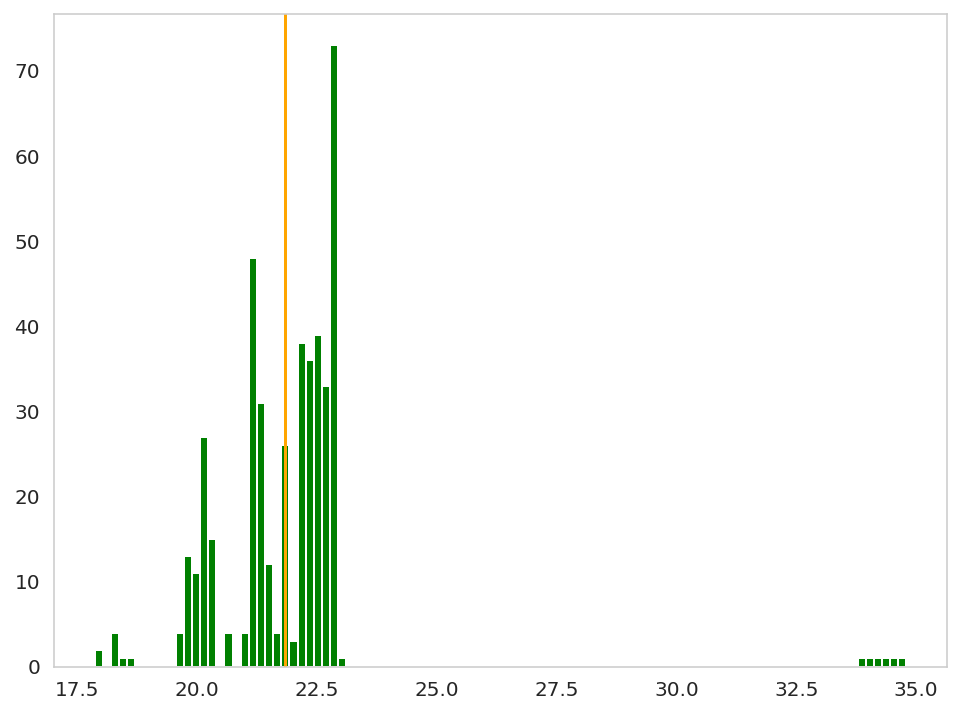

In [57]:
fig = plt.figure(figsize=(8, 6))

ax = plt.hist(df2g['log_copyNum'],100, color='green')

plt.axvline(x=np.log(3*1e9),c='orange')
#plt.axvline(x=np.log(1.0),c='purple')

plt.grid(False)

plt.show()

#fig.savefig('../plots/suppValid_totalProteinPerSample.png',dpi=300, bbox_inches='tight', transparent=True)
#fig.savefig('../plots/suppValid_totalProteinPerSample.svg', transparent=True)


In [13]:
np.max(df.loc[~df['copyNum'].isna(),'copyNum'])

9590670714360978.0

In [14]:
df.loc[(~df['totalProtein'].isna()) & (df['copyNum']==9590670714360978.0),'gene_id_final'].unique()

array(['FABP7'], dtype=object)

In [15]:
df.loc[(~df['totalProtein'].isna()) & (df['copyNum']==9590670714360978.0)].head()

,gene_names,Uniprot,Study,Organism,location,Age_cat,Age_days,condition,sample_id,molecular_weight_kDa,raw_data,raw_data_units,gene_name_unified,Uniprot_unified,gene_id_final,log_raw_data,uniprot_from_gn,Uniprot_final,TheorPepNum,conc_uM,log_conc_uM,copyNum,totalProtein,totalVolume,sample_full_id,compound_gene_protein_id,row_id,row_gene_id,gene_id_dd,log_conc_uM_medNorm,exp_conc
2130921,FABP7,NaN,Duda 2018,mouse,cerebellum,young,51,young,NaN,14.893,79.62841,Mean concentration [mol/(g total protein)],FABP7,None,FABP7,4.377371,"[P51880, P55051, O15540]",P51880,None,1048.48,6.955096,9.59067e+15,3.03786e+09,1.51893e+10,Duda 2018_mouse_cerebellum_51.0_young_nan,FABP7#P51880,FABP7#P51880@Duda 2018_mouse_cerebellum_51.0_y...,FABP7@Duda 2018_mouse_cerebellum_51.0_young_nan,None,3.2418,25.579728
